# Count codons
This notebook takes FASTQ files and uses dms_tools2 to calculate the frequency of codons at mutagenezed sites in the Zika Virus NS5 protein.

FASTQ files for each cell population are specified in `samplesheet.csv`.

## Notebook setup
Imports

In [1]:
import dms_tools2
import numpy as np
import os
import pandas as pd
import plotnine as p9
import regex
from Bio import SeqIO
from dms_tools2.ipython_utils import showPDF

# print imports and versions
# copied from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
print('\n'.join(f'{m.__name__}=={m.__version__}' \
                for m in globals().values() if getattr(m, '__version__', None)))

dms_tools2==2.6.8
numpy==1.19.1
pandas==0.25.3
plotnine==0.6.0
regex==2.5.83


Input data

In [2]:
sequencing_dir = '/shared/ngs/illumina/bloom_lab/211223_M03100_0703_000000000-K5NB5/Unaligned/Project_bloom_lab/'
samplesheet = 'data/samplesheet.csv'
reference_file = 'data/ns5.fasta'
alignspecs_file = 'data/alignspecs.txt'

Output data

In [3]:
results_dir = 'results/'

Analysis parameters

Notebook aesthetics

In [4]:
p9.theme_set(p9.theme_classic())
CBPALETTE_RICH = ['#648FFF', '#FFB000', '#DC267F', '#785EF0', '#FE6100']

## Load data
Load samples

In [5]:
samples = pd.read_csv(samplesheet)
samples.insert(0, 'name', (samples['library'] + '-' +
                           samples['source'] + '-' +
                           samples['stage'] + '-' +
                           samples['sorted']))
samples['r1_file_long'] = sequencing_dir + samples['r1_file']
display(samples)

,name,library,source,stage,sorted,r1_file,r1_file_long
0,wt-plasmid-noStage-notSorted,wt,plasmid,noStage,notSorted,BR_WT_Plasmid_S1_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
1,wt-gDNA-noStage-notSorted,wt,gDNA,noStage,notSorted,BR_WT_NS5_gDNA_S17_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
2,lib1-plasmid-noStage-notSorted,lib1,plasmid,noStage,notSorted,BR_Lib_1_Plasmid_S2_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
3,lib2-plasmid-noStage-notSorted,lib2,plasmid,noStage,notSorted,BR_Lib_2_Plasmid_S3_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
4,lib3-plasmid-noStage-notSorted,lib3,plasmid,noStage,notSorted,BR_Lib_3_Plasmid_S4_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
5,lib1-gDNA-early-notSorted,lib1,gDNA,early,notSorted,BR_Lib_1_Early_gDNA_S5_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
6,lib2-gDNA-early-notSorted,lib2,gDNA,early,notSorted,BR_Lib_2_Early_gDNA_S6_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
7,lib3-gDNA-early-notSorted,lib3,gDNA,early,notSorted,BR_Lib_3_Early_gDNA_S7_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
8,lib1-gDNA-mid-notSorted,lib1,gDNA,mid,notSorted,BR_Lib_1_Mid_gDNA_S8_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
9,lib2-gDNA-mid-notSorted,lib2,gDNA,mid,notSorted,BR_Lib_2_Mid_gDNA_S9_R1_001.fastq.gz,/shared/ngs/illumina/bloom_lab/211223_M03100_0...


Load reference sequence

In [6]:
reference = SeqIO.read(reference_file, 'fasta')
ref_seq = reference.seq

print(f'The reference sequence name is: {reference.id}')
print(f'The nucleotide sequence is:\n{ref_seq}')

The reference sequence name is: NS5
The nucleotide sequence is:
GGAGGTGGGACGGGAGAGACTCTGGGAGAGAAGTGGAAAGCTCGTCTGAATCAGATGTCGGCCCTGGAGTTCTACTCTTATAAAAAGTCAGGTATCACTGAAGTGTGTAGAGAGGAGGCTCGCCGTGCCCTCAAGGATGGAGTGGCCACAGGAGGACATGCCGTATCCCGGGGAAGTGCAAAGCTCAGATGGTTGGTGGAGAGAGGATATCTGCAGCCCTATGGGAAGGTTGTTGACCTCGGATGTGGCAGAGGGGGCTGGAGCTATTATGCCGCCACCATCCGCAAAGTGCAGGAGGTGAGAGGATACACAAAGGGAGGTCCCGGTCATGAAGAACCCATGCTGGTGCAAAGCTATGGGTGGAACATAGTTCGTCTCAAGAGTGGAGTGGACGTCTTCCACATGGCGGCTGAGCCGTGTGACACTCTGCTGTGTGACATAGGTGAGTCATCATCTAGTCCTGAAGTGGAAGAGACACGAACACTCAGAGTGCTCTCTATGGTGGGGGACTGGCTTGAAAAAAGACCAGGGGCCTTCTGTATAAAGGTGCTGTGCCCATACACCAGCACTATGATGGAAACCATGGAGCGACTGCAACGTAGGCATGGGGGAGGATTAGTCAGAGTGCCATTGTCTCGCAACTCCACACATGAGATGTACTGGGTCTCTGGGGCAAAGAGCAACATCATAAAAAGTGTGTCCACCACAAGTCAGCTCCTCCTGGGACGCATGGATGGCCCCAGGAGGCCAGTGAAATATGAGGAGGATGTGAACCTCGGCTCGGGTACACGAGCTGTGGCAAGCTGTGCTGAGGCTCCTAACATGAAAATCATCGGCAGGCGCATTGAGAGAATCCGCAATGAACATGCAGAAACATGGTTTCTTGATGAAAACCACCCATACAGGACATGGGCCTACCATGGGAGCTACGAAGCC

Read in alignment specs:

In [7]:
with open (alignspecs_file, 'r') as file:
    alignspecs = file.read().replace('\n','')

print('The alignment specs are:\n')
print(alignspecs)

The alignment specs are:

1951,2285,33,32


## Count codon frequencies
Use `dms_tools2` to count codon frequencies in sequencing data

Setup:

In [8]:
# Set up results dir
codon_counts_dir = os.path.join(results_dir + '/' + 'codon_counts')
os.makedirs(codon_counts_dir, exist_ok=True)

# Make samplesheet
batchfile = os.path.join(codon_counts_dir + 'batchfile.csv')
batchfile_list = []
for index, sample in samples.iterrows():
    batchfile_list.append(sample[['name', 'r1_file_long']])
batchfile_df = pd.DataFrame(batchfile_list)
batchfile_df = batchfile_df.rename(columns={'r1_file_long': 'R1'})
display(batchfile_df)

print(f'Writing batchfile to {batchfile}')
batchfile_df.to_csv(batchfile, index=False)
print('Done.')


,name,R1
0,wt-plasmid-noStage-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
1,wt-gDNA-noStage-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
2,lib1-plasmid-noStage-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
3,lib2-plasmid-noStage-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
4,lib3-plasmid-noStage-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
5,lib1-gDNA-early-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
6,lib2-gDNA-early-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
7,lib3-gDNA-early-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
8,lib1-gDNA-mid-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...
9,lib2-gDNA-mid-notSorted,/shared/ngs/illumina/bloom_lab/211223_M03100_0...


Writing batchfile to results/codon_countsbatchfile.csv
Done.


Command:

In [9]:
ncpus = 16

R1_trim = 200
R2_trim = 200

# Overwrite or use existing results
use_existing = 'no'

print('Running dms_tools2')
log = ! dms2_batch_bcsubamp \
        --batchfile {batchfile} \
        --refseq {reference_file} \
        --alignspecs {alignspecs} \
        --outdir {codon_counts_dir} \
        --summaryprefix summary \
        --R1trim {R1_trim} \
        --R2trim {R2_trim} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codon_counts_file'] = codon_counts_dir + '/' + samples['name'] + '_codoncounts.csv'

# check that expected codon counts files created
assert all(map(os.path.isfile, samples.codon_counts_file)), '\n'.join(log)

print(f"Processed sequencing data to create codon counts files in {codon_counts_dir}")

Running dms_tools2
Processed sequencing data to create codon counts files in results/codon_counts


## Visualize results
**Reads and barcodes per sample:**

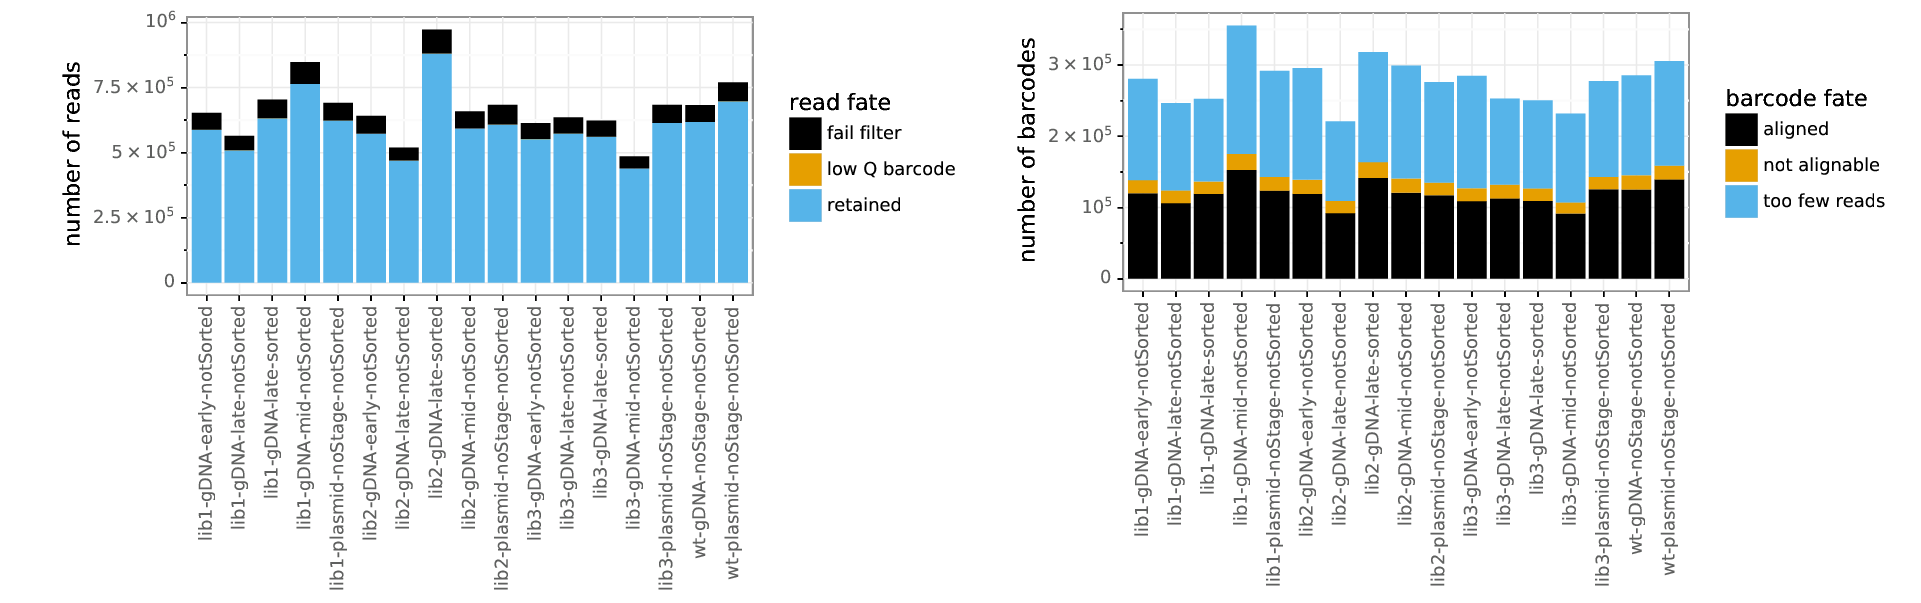

In [11]:
showPDF([os.path.join(codon_counts_dir + "/" + "summary_readstats.pdf"),
         os.path.join(codon_counts_dir + "/" + "summary_bcstats.pdf")])

Interpretation:  ~5e5 reads per sample; I think we shot for 1M reads per sample, so this is low. ~1e5 valid barcodes per sample, and about the same number with too few reads. More sequencing could potentially double the number of barcodes we use to quantify codons.

**Barcode coverage:**

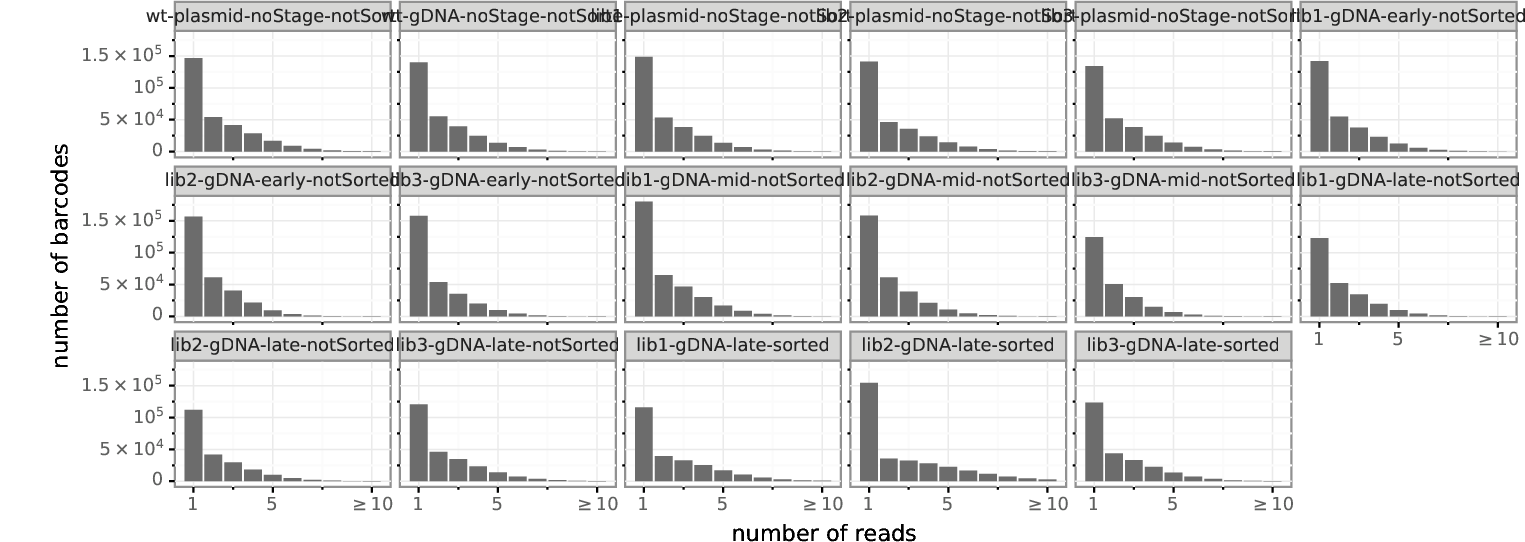

In [14]:
showPDF(os.path.join(codon_counts_dir + "/" + "summary_readsperbc.pdf"))

Interpretation: Lots of barcodes are only covered by a single read. More sequencing depth would improve coverage.

**Mutation frequency:**

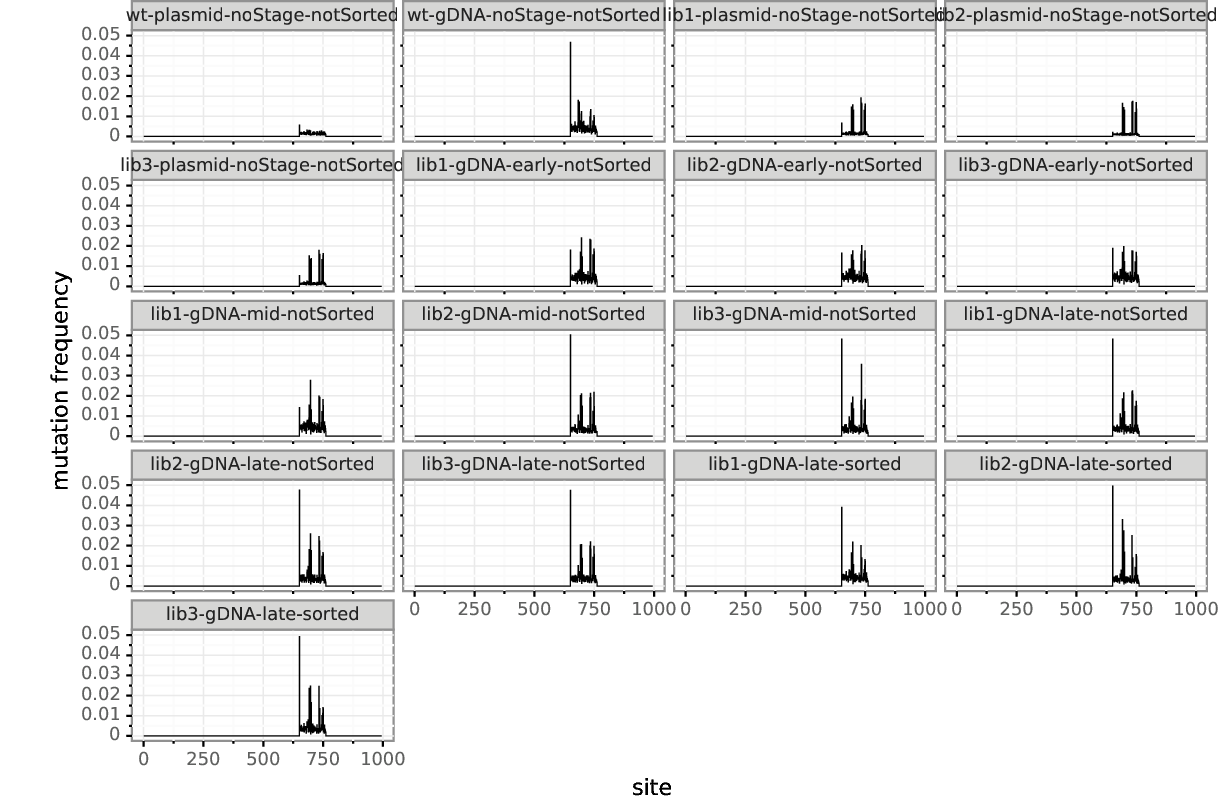

In [16]:
showPDF([os.path.join(codon_counts_dir + "/" + "summary_mutfreq.pdf")])

Interpretation:  The line plots are hard to interpret. Clearly, the `WT plasmid` sample has fewer mutations than other samples.

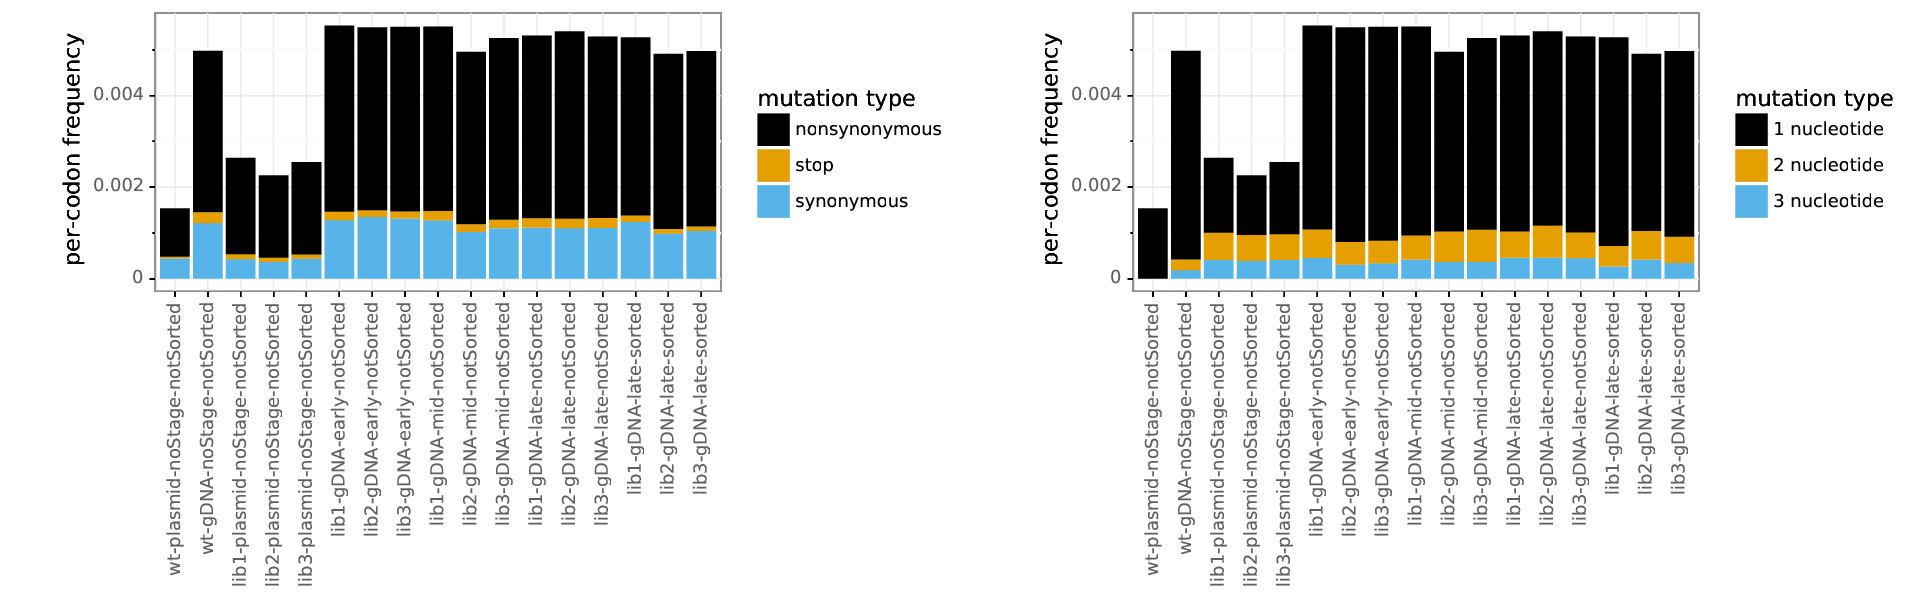

In [20]:
showPDF([os.path.join(codon_counts_dir + "/" + "summary_codonmuttypes.pdf"),
         os.path.join(codon_counts_dir + "/" + "summary_codonntchanges.pdf")])

Intepretation: These plots are easier to interpret. The WT plasmid sample has a low mutation rate, compared to other samples. Integration seems to increase mutation rate substantially, to the point where it is close to the mutated libraries. The mutated plasmid libraries have an increased mutation rate, as well.